## ALLN - Antenna lobe local neuron
This notebook contains basic analysis about local neurons in the antenna lobe present in the `hemibrain` dataset. Different analysis include basic summary of the neuron types, plotting etc.

### Dependencies
You will need the following dependencies which can be installed using `pip`:
1. [neuprint-python](https://github.com/connectome-neuprint/neuprint-python): `pip3 install neuprint-python`
2. [navis](https://navis.readthedocs.io/en/latest/): `pip3 install navis` 

In addition, you will need to have your neuPrint authorization token set as environmental variable. See neuprint-python's [docs](https://connectome-neuprint.github.io/neuprint-python/docs/)

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
sns.set_color_codes('muted')

In [3]:
label_fontsize = 16 
title_fontsize = 18

In [4]:
import navis
print('navis version:', navis.__version__)

navis version: 0.3.2


In [5]:
import navis.interfaces.neuprint as neu
client = neu.Client('https://neuprint.janelia.org/', dataset='hemibrain:v1.1')

In [6]:
#navis display options for frontal view..
elev = -180
azim = -90
dist = 6

# 1. Load the datasheet from the google drive, this will contains bodyIds, types and morphological details

In [7]:
url = 'https://drive.google.com/file/d/1ACJ0u7WxjkUil0jJFd5Bkwl3w1MgwUhZ/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

In [8]:
al_datasheet = pd.read_csv(path)

In [9]:
al_datasheet.head()

,bodyid,pre,post,upstream,downstream,status,name,voxels,soma,side,...,axon.outputs,dend.outputs,axon.inputs,dend.inputs,total.length,axon.length,dend.length,pd.length,segregation_index,notes
0,1578826464,1900,7210,7210,7501,Traced,lLN1_c_R,2691885349,True,right,...,2207,5221,2092,5098,9754.820208,2399.378774,5678.107814,66.080358,0.000033,Type: broad LN belonging to the LN1 type (Tana...
1,1670278227,180,271,271,1044,Traced,lLN11_R,373927384,True,right,...,1038,5,110,160,1372.668174,717.893513,440.538674,39.312691,0.423012,Type: weak regional or sparse LNs with a simil...
2,1979569670,107,185,185,535,Traced,lLN11_R,271448716,True,right,...,431,89,103,71,886.728404,328.465711,333.355105,118.997320,0.048766,Type: weak regional or sparse LNs with a simil...
3,2040301572,198,372,372,1116,Traced,lLN11_R,367013585,True,right,...,216,814,29,324,1437.415433,160.300071,918.722654,107.007237,0.021254,Type: weak regional or sparse LNs with a simil...
4,1826445251,207,381,381,1233,Traced,lLN12a_R,390802154,True,right,...,1221,9,166,211,1667.833740,788.073478,597.583386,32.278918,0.376746,Type: regional LNs that innervate the same are...


In [10]:
#filter annotations to usable details now..
al_annotations = al_datasheet[['bodyid','name','soma','anatomy.group','segregation_index']]
#rename then to neuprint types..
al_annotations = al_annotations.rename(columns={'bodyid': 'bodyId', 'name': 'type','anatomy.group': 'morpho_group'})

In [11]:
al_annotations

,bodyId,type,soma,morpho_group,segregation_index
0,1578826464,lLN1_c_R,True,l_LN_broad_,0.000033
1,1670278227,lLN11_R,True,l_LN_regional_,0.423012
2,1979569670,lLN11_R,True,l_LN_regional_,0.048766
3,2040301572,lLN11_R,True,l_LN_regional_,0.021254
4,1826445251,lLN12a_R,True,l_LN_regional_,0.376746
...,...,...,...,...,...
192,5813040492,v2LN38_L,False,v2contra_LN_sparse_bil,0.005862
193,5813071384,vLN26_R,True,v_LN_sparse_bil,0.209587
194,2101391269,vLN28_R,False,v_LN_sparse_,0.508483
195,5813055448,vLN29_R,True,v_LN_sparse_,0.472716


In [12]:
al_comp = al_annotations[['bodyId','type', 'morpho_group']]
al_comp = al_comp.rename(columns={'bodyId': 'BodyId', 'type': 'Type','morpho_group': 'morphology'})
al_comp = al_comp.sort_values('BodyId')
al_comp = al_comp.reset_index(drop = True)
al_comp = al_comp[['BodyId','morphology']]
al_comp

,BodyId,morphology
0,1547454812,l_LN_broad_
1,1578826464,l_LN_broad_
2,1610530558,l_LN_broad_
3,1639886198,l_LN_patchy_
4,1640555311,l_LN_patchy_
...,...,...
192,5901197989,l_LN_sparse_bil
193,5901198734,v2_LN_regional_bil
194,5901199598,v2_LN_sparse_bil
195,5901206553,il3_LN_broad_


In [13]:
#remove the contralateral LN, though it is typed, it is coming from the other side so we do not use it..
al_lns = al_annotations[~al_annotations['morpho_group'].str.startswith('v2contra_')]

In [14]:
print('--- Summary of local neuron types in antenna lobe ---\n')

print('--- Total ---')
print('Typed Antenna lobe neurons:', len(al_annotations))
print('Antenna lobe neurons (used in analysis):', len(al_lns))

print('\n--- By cross over ---')
# Bilateral neurons..
bilateral_lns = al_lns[al_lns['morpho_group'].str.contains('_bil')]
unilateral_lns = al_lns[al_lns['morpho_group'].str.endswith('_')]
print('Bilateral:', len(bilateral_lns))
print('Unilateral:', len(unilateral_lns))
print('Total:', len(bilateral_lns)+ len(unilateral_lns))

print('\n--- By lineage ---')
# v neurons..
v_lns = al_lns[al_lns['morpho_group'].str.startswith('v_')]
# v2 neurons..
v2_lns = al_lns[al_lns['morpho_group'].str.startswith('v2_')] #there is v2, and also v2contra

# il3 neurons..
il3_lns = al_lns[al_lns['morpho_group'].str.startswith('il3_')]
# l neurons..
l_lns = al_lns[al_lns['morpho_group'].str.startswith('l_')]
# l2 neurons..
l2_lns = al_lns[al_lns['morpho_group'].str.startswith('l2_')]
# contra neurons..
contra_lns = al_annotations[al_annotations['morpho_group'].str.contains('contra_')]
# unknownlineage neurons..
unknownlineage_lns = al_annotations[al_annotations['morpho_group'].str.startswith('_')]

print('v:', len(v_lns))
print('v2:', len(v2_lns))
print('il3:', len(il3_lns))
print('l:', len(l_lns))
print('l2:', len(l2_lns))
print('Contra:', len(contra_lns))
print('unknown:', len(unknownlineage_lns))
print('Total:', len(v_lns)+ len(v2_lns) + len(il3_lns)+ len(l_lns)+len(l2_lns)+
      len(contra_lns)+len(unknownlineage_lns))


print('\n--- By morphology ---')
# sparse neurons..
sparse_lns = al_lns[al_lns['morpho_group'].str.contains('_sparse_')]
# regional neurons..
regional_lns = al_lns[al_lns['morpho_group'].str.contains('_regional_')]
# broad neurons..
broad_lns = al_lns[al_lns['morpho_group'].str.contains('_broad_')]
# patchy neurons..
patchy_lns = al_lns[al_lns['morpho_group'].str.contains('_patchy_')]
# unknown neurons..
unknownmorpho_lns = al_lns[al_lns['morpho_group'].str.contains('LN__')]

print('sparse:', len(sparse_lns))
print('regional:', len(regional_lns))
print('broad:', len(broad_lns))
print('patchy:', len(patchy_lns))
print('unknown:', len(unknownmorpho_lns))
print('Total:', len(sparse_lns)+ len(regional_lns)+ len(broad_lns)+len(patchy_lns)+len(unknownmorpho_lns))


--- Summary of local neuron types in antenna lobe ---

--- Total ---
Typed Antenna lobe neurons: 197
Antenna lobe neurons (used in analysis): 196

--- By cross over ---
Bilateral: 78
Unilateral: 118
Total: 196

--- By lineage ---
v: 8
v2: 81
il3: 2
l: 95
l2: 10
Contra: 1
unknown: 0
Total: 197

--- By morphology ---
sparse: 98
regional: 42
broad: 42
patchy: 14
unknown: 0
Total: 196


## convert the above information to a table format for display..

In [15]:
table_lns = al_lns.copy()
table_lns['lineage'] = table_lns.morpho_group.map(
                                lambda x: x.split('_')[0].lower())
table_lns['morpho_type'] = table_lns.morpho_group.map(
                                lambda x: x.split('_')[2].lower())
columns = ['bodyId','type', 'soma', 'morpho_group','segregation_index']
table_lns.drop(columns, inplace=True, axis=1)
table_lns = table_lns[table_lns.morpho_type != '']
table_lns = table_lns[(table_lns.lineage != '') & (table_lns.lineage != 'contra')]

table_lns.loc[table_lns.lineage == '','lineage'] = 'unknown'
table_lns.loc[table_lns.morpho_type == '','morpho_type'] = 'unknown'

#change contralateral stuff for which lineages are known to simple lineages
table_lns.loc[table_lns.lineage == 'v2contra','lineage'] = 'v2'

table_lns.head()

,lineage,morpho_type
0,l,broad
1,l,regional
2,l,regional
3,l,regional
4,l,regional


In [16]:
table_lns.lineage.unique()

array(['l', 'l2', 'v', 'v2', 'il3'], dtype=object)

In [17]:
table_lns_print = table_lns.pivot_table(index='morpho_type', columns='lineage', 
                        aggfunc=len, fill_value=0)
table_lns_print.loc['Total']= table_lns_print.sum(numeric_only=True, axis=0)
table_lns_print.loc[:,'Total'] = table_lns_print.sum(numeric_only=True, axis=1)
table_lns_print = table_lns_print.astype('float')
table_lns_print

lineage,il3,l,l2,v,v2,Total
morpho_type,,,,,,
broad,2.0,39.0,1.0,0.0,0.0,42.0
patchy,0.0,14.0,0.0,0.0,0.0,14.0
regional,0.0,19.0,0.0,4.0,19.0,42.0
sparse,0.0,23.0,9.0,4.0,62.0,98.0
Total,2.0,95.0,10.0,8.0,81.0,196.0


In [18]:
table_lns_mask= table_lns_print*0
table_lns_mask.loc['Total'] = 1
table_lns_mask.loc[:,'Total'] = 1

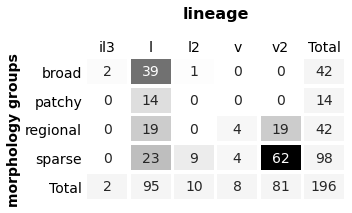

In [19]:
fig, ax = plt.subplots(figsize=(5, 3))

ax = sns.heatmap(table_lns_print, cmap='Greys', annot=True, fmt='.0f', ax=ax, mask=table_lns_mask == 1,
                 cbar=False, annot_kws={"size": 14},linewidths=2.5)
ax = sns.heatmap(table_lns_print, cmap=ListedColormap(['whitesmoke']), annot=True, fmt='.0f', ax=ax, 
                 mask=table_lns_mask != 1,cbar=False, annot_kws={"size": 14},linewidths=2.5)

ax.set_xlabel('')
ax.set_ylabel('')


ax.tick_params(axis=u'both', which=u'both', length=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size=label_fontsize-2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, size=label_fontsize-2)
plt.tick_params(axis='both', which='major', labelsize=label_fontsize-2, labelbottom = False, 
                bottom=False, top = False, labeltop=True)

plt.xlabel('lineage\n', fontsize = label_fontsize,weight = 'bold')
plt.ylabel('morphology groups', fontsize = 14,weight = 'bold')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.box(False)

# 2. Fetch skeletons from neuprint for display

In [20]:
bodyidList = al_lns.bodyId.tolist()
len(bodyidList)

196

In [21]:
#fetch skeletons and heal fragments within a specific threshold..
alln_skel = neu.fetch_skeletons(bodyidList, heal=1000, max_threads=30)

In [22]:
alln_skel.head()

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,navis.TreeNeuron,lLN16b_R,1701965055,3904,241,151,None,108657.062500,23,8 nanometer
1,navis.TreeNeuron,v2LN34e_R,1670636531,3706,382,180,None,159913.359375,3677,8 nanometer
2,navis.TreeNeuron,lLN11_R,1670278227,4295,451,142,None,171583.515625,864,8 nanometer
3,navis.TreeNeuron,v2LN34f_R,1668275074,6885,713,331,None,249866.812500,6826,8 nanometer
4,navis.TreeNeuron,lLN12b_R,1671270875,5003,913,288,None,195711.937500,7,8 nanometer


In [23]:
def plotskeletons(plotting_skel, color, scaling_skel, axes, alpha = 0.4, outline = False):
    if outline == True:
        p_al = Poly3DCollection([al_outlines[:, [0, 2, 1]]], linewidth=1.5, 
                        facecolor=(0, 0, 0, 0), edgecolor=(0, 0, 0, 1), linestyle='-')
        axes.scatter(al_outlines[:,0],al_outlines[:,2],al_outlines[:,1], alpha = 0)
        axes.add_collection3d(p_al)
    else:
        navis.plot2d(al,ax=ax,method='3d', lw=.8)
    navis.plot2d(scaling_skel, method='3d', ax = ax, connectors=False, color = 'black', linewidth=0, alpha = 0)
    navis.plot2d(plotting_skel, method='3d', ax = axes, connectors=False, color = color, linewidth=1, alpha = alpha)
    # Rotate to frontal view
    axes.elev = elev
    axes.azim = azim
    axes.dist = dist
    return axes

In [24]:
#fetch mesh for Right Antenna lobe..
al = neu.fetch_roi('AL(R)')
al.color = (.9, .9, .9, .05)
al

<navis.Volume(name=AL(R), color=(0.9, 0.9, 0.9, 0.05), vertices.shape=(38829, 3), faces.shape=(77672, 3))>

In [25]:
# Generate 2D outlines for the al (not required, but useful for other kinds of display)
al2d = np.array(al.to_2d(alpha = 2,view = 'xz'))
al_outlines = np.append(al2d, np.repeat(al.center[2], al2d.shape[0]).reshape(al2d.shape[0], 1), axis=1)

In [26]:
figwidth_size = 5
figheigth_size = 5

## Bilateral/Unilateral neurons

In [27]:
#get bilateral neurons
billn_skel = alln_skel[np.in1d(alln_skel.id, bilateral_lns.bodyId)]
#get uni neurons
uniln_skel = alln_skel[np.in1d(alln_skel.id, unilateral_lns.bodyId)]

In [28]:
#this is just for consistent display distance..
scaling_skel = billn_skel[np.in1d(billn_skel.id, [1698679708,2041993364])]

In [29]:
skelbg_color = 'grey'

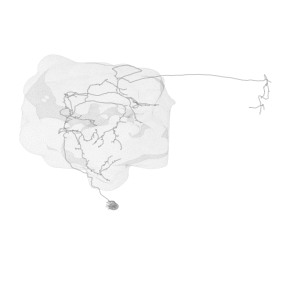

In [30]:
# Make a 2d plot
fig = plt.figure(figsize=(figwidth_size, figheigth_size))
ax = fig.add_subplot(1, 1, 1, projection = '3d')
plotbilln_skel = billn_skel
ax = plotskeletons(plotting_skel = plotbilln_skel[0], color = skelbg_color, scaling_skel = scaling_skel, 
             axes = ax)

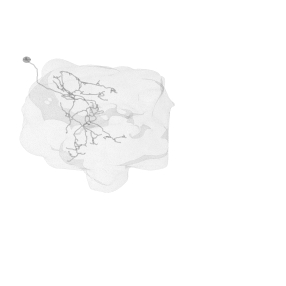

In [31]:
# Make a 2d plot
fig = plt.figure(figsize=(figwidth_size, figheigth_size))
ax = fig.add_subplot(1, 1, 1, projection = '3d')
plotuniln_skel = uniln_skel
ax = plotskeletons(plotting_skel = plotuniln_skel[0], color = skelbg_color, scaling_skel = scaling_skel, 
             axes = ax)

## Morphological types

In [32]:
def plotmorphotypeskeletons(plotting_skel, scaling_skel, axes, color,alpha = 1):
    navis.plot2d(al,ax=ax,method='3d', lw=.8)
    navis.plot2d(scaling_skel, method='3d', ax = ax, connectors=False, color = 'black', linewidth=0, alpha = 0)
    navis.plot2d(plotting_skel, method='3d', ax = axes, connectors=False, color = color, linewidth=1, alpha = alpha)
    # Rotate to frontal view
    axes.elev = elev
    axes.azim = azim
    axes.dist = dist
    return axes

In [33]:
sparseln_skel = alln_skel[np.in1d(alln_skel.id, sparse_lns.bodyId)]
regionalln_skel = alln_skel[np.in1d(alln_skel.id, regional_lns.bodyId)]
broadln_skel = alln_skel[np.in1d(alln_skel.id, broad_lns.bodyId)]
patchyln_skel = alln_skel[np.in1d(alln_skel.id, patchy_lns.bodyId)]

### Sparse

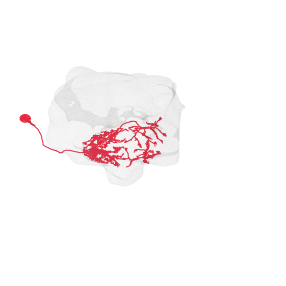

In [34]:
# Make a 2d plot
fig = plt.figure(figsize=(figwidth_size, figheigth_size))
ax = fig.add_subplot(1, 1, 1, projection = '3d')
sparseln_skel_plot = sparseln_skel[np.in1d(sparseln_skel.id, [1976565858])]
sparse_col = [0.905, 0.152, 0.243]
ax = plotmorphotypeskeletons(plotting_skel = sparseln_skel_plot, color = sparse_col, 
                             scaling_skel = scaling_skel,axes = ax)

### regional

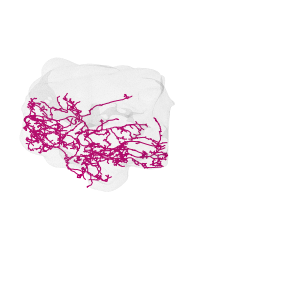

In [35]:
# Make a 2d plot
fig = plt.figure(figsize=(figwidth_size, figheigth_size))
ax = fig.add_subplot(1, 1, 1, projection = '3d')
regionalln_skel_plot = regionalln_skel[np.in1d(regionalln_skel.id, [5813018729])]
regional_col = [0.721, 0.0, 0.407]
ax = plotmorphotypeskeletons(plotting_skel = regionalln_skel_plot, color = regional_col, 
                             scaling_skel = scaling_skel, axes = ax)

### broad

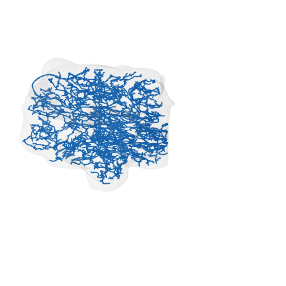

In [36]:
# Make a 2d plot
fig = plt.figure(figsize=(figwidth_size, figheigth_size))
ax = fig.add_subplot(1, 1, 1, projection = '3d')
broadln_skel_plot = broadln_skel[np.in1d(broadln_skel.id, [5813130064])]
broad_col = [0.047, 0.376, 0.698]
ax = plotmorphotypeskeletons(plotting_skel = broadln_skel_plot, color = broad_col, 
                             scaling_skel = scaling_skel, axes = ax)

### patchy

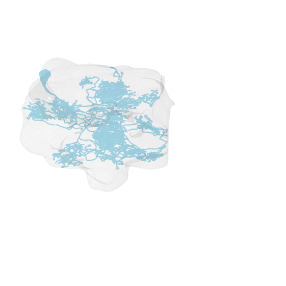

In [37]:
# Make a 2d plot
fig = plt.figure(figsize=(figwidth_size, figheigth_size))
ax = fig.add_subplot(1, 1, 1, projection = '3d')
patchyln_skel_plot = patchyln_skel[np.in1d(patchyln_skel.id, [1670916819])]
patchy_col = [0.631, 0.847, 0.921]
ax = plotmorphotypeskeletons(plotting_skel = patchyln_skel_plot, color = patchy_col, 
                             scaling_skel = scaling_skel, axes = ax)